#### Group 12 - Robo Advising:
- Team Number: <font color="gold"> 12 </font>
- Team Member Names: <font color="gold"> Robin Zhang, Jessica Chen, Eric Wang </font>
- Team Strategy Chosen: <font color="red"> Risky </font>

In [15]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import threading


#### Rational Overview:
1. undo all the diversification
2. only do the bare minimum diversification required by the assignment
3. find riskiest stock using standard deviation, call it mainStock (although variance will work equally well)
4. build a portfolio with the least amount of stocks allowed to perserve the risky nature of mainStock and avoid diversification
    1. to do so: find the 11 other stocks with high correlation to mainStock (ensure they move in same direction)
    2. gave the highest weight to mainStock, the stock with highest Correlation to mainStock. And give the stock with second highest Correlation enough weight such that the rest of the stocks will have minimum required weighting
    3. by doing so, we are preserving the nature risky nature of mainStock by avoiding diversification at all cost

In [16]:
# All subsequent data retrieval will use the given dates
start_date = "2021-11-25"
end_date = "2022-11-25"

We chose the data range to be within a year to avoid extraneous circumstances in the past that is no longer applicable to our current analysis. For example, if we include data from 2020, we would have included data from a period of extreme uncertainty which might not reflect the regular movement of the stock.

In [17]:
def filter(filename):
    #Call the CSV file and store it in a dataframe
    tickers = pd.read_csv(filename)
    length = len(tickers)

    #Clean the the dataframe
    colname = tickers.columns[0]

    #rename tickers columns and create missing_data dataframe
    tickers.columns = ['Tickers']
    missing_data = pd.DataFrame({'Tickers': [colname]})

    #append the two dataframes
    tickers = pd.concat([missing_data, tickers])

    tickers.reset_index(inplace=True, drop=True)
    #make list of tickers
    ticker_list = list(tickers.Tickers)

    #set the start and end dates for the filter
    start_date_filter = '2022-01-01'
    end_date_filter = '2022-10-01'
    #empty series to hold volume of tickers
    ticker_data = {}
    #empty list to temporarily hold the sorted tickers
    new_lst = []

    def checkTicker(ticker):
        #get the historical data for the ticker
        firm = yf.Ticker(ticker)
        firm_hist = firm.history(start=start_date_filter, end=end_date_filter, interval='1mo')
        firm_hist.reset_index(inplace=True)

        #filter and remove rows that do not have at least 20 business days
        for x in range(len(firm_hist)-1):
            #x should 
            first_month = firm_hist.iloc[x, 0].strftime('%Y-%m-%d')
            next_month = firm_hist.iloc[x+1, 0].strftime('%Y-%m-%d')
            if np.busday_count(first_month, next_month) < 20:
                #drop the row of hist
                firm_hist.drop([x, 0])


        ticker_data[t] = firm_hist.Volume

        if ticker_data[t].mean() > 200000:
            #make a new lst that stores the values where mean >200 000
            #return that list
            new_lst.append(ticker)
    
    Threads=[]
    
    for ticker in ticker_list:
        # start a thread t each time we call t
        t = threading.Thread(target=checkTicker, args=[ticker])
        t.start()
        # Puts them into a list so can join() later
        Threads.append(t)

    for thread in Threads:
        # join the threads together to run concurrently
        thread.join()
    
    ticker_list = new_lst
    #remove all tickers not listed on US market
    #by deleting all values with a "." in them
    for t in ticker_list:
        if "." in t:
            ticker_list.remove(t)

    return ticker_list


In [18]:
ticker_list = filter('Tickers_Example.csv')
print(ticker_list)

- AGN: No data found, symbol may be delisted- CELG: No data found, symbol may be delisted

- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
['AMZN', 'BAC', 'ABBV', 'AXP', 'CVS', 'BA', 'AAPL', 'BIIB', 'TSLA', 'CAT', 'BLK', 'COF', 'ABT', 'C', 'GOOG', 'COST', 'GM', 'AIG', 'CMCSA', 'JPM', 'BMY', 'ACN', 'LMT', 'KMI', 'MRK', 'CL', 'LLY', 'BK', 'CSCO', 'ORCL', 'COP', 'MSFT', 'NKE', 'MON', 'KO', 'MO', 'MS', 'PYPL', 'SBUX', 'QCOM', 'TD.TO', 'UNH', 'SPG', 'USB', 'TGT', 'OXY', 'NEE', 'PEP', 'SO', 'PM', 'TXN', 'PFE', 'SLB', 'UNP', 'T', 'UPS', 'PG']


The above tickers are the valid US ticker strings that we use to create "Stock" objects. The below "Stock" class is used to create objects that hold vital calculations/data of the given stocks

In [28]:
class Stock:
    
    '''
    Attributes for each "Stock" object:
        ticker (string): represents a US ticker string
        start (datetime): represents the start date of the yfinance data
        end (datetime): represents the end date of the yfinance data
        marketTicker (string): the string "^GSPC" that represents the SP500 index
        companies (dictionary): used to create companiesDF
        columns (list): a list of columns used to create companiesDF
        companiesDF (dataframe): a dataframe with columns "(ticker)", "pct", "^GSPC" and date as index
        std (Float): a number represending the standard deviation of a stock's returns
    '''
    
    # Initializing values when class is created
    def __init__(self, ticker, start, end, market='^GSPC'):
        
        # Initializing the Parameters of the Function
        self.ticker = ticker
        self.start = start
        self.end = end
        
        # Market for having data to compare to the market if needs be
        self.marketTicker = market
        
        #Calls most functions to set up the data
        self.makeDataDict()
        self.makeDataFrame()
        self.makeColumns()
        self.getSTD()
        
    # Value to output when outputing the Class
    def __str__(self):
        return self.ticker + ": " + str(self.std)

    
    # This function allow us to sort instances of the class based on their std
    def __gt__(self, other):
        return self.std < other.std

    # Takes the history of the ticker and market and puts in dictionary
    def makeDataDict(self):
        self.companies = {}
        self.companies[self.ticker] = yf.Ticker(self.ticker).history(start = self.start, end = self.end)['Close']
        self.companies[self.marketTicker] = yf.Ticker(self.marketTicker).history(start = self.start, end = self.end)['Close']


    # Creates a DataFrame for the Data, Get its intervals by the weekly
    def makeDataFrame(self):
        self.companiesDF = pd.DataFrame(self.companies)
        
        self.companiesDF = self.companiesDF.groupby(pd.Grouper(axis=0, freq='1W')).first()
        # Creates a column to check percentage change
        self.companiesDF['pct']=self.companiesDF[self.ticker].pct_change() 
    
    # When there are modification to the class, this function will recalculate the pct change and std
    def checkValues(self):
        self.companiesDF['pct']=self.companiesDF[self.ticker].pct_change() 
        self.getSTD()
    
    # Used to Check the columns if needs to loop over the code
    def makeColumns(self):
        self.columns = []
        for column in self.companiesDF.iteritems():
            self.columns.append(column[0])
    
    # Graphs the pct change of the ticker over the span of time indicated
    def graphChange(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        plt.plot(self.dateRange, self.companiesDF['pct'], label= self.ticker + ": "+  str(self.std) )
        plt.title("Portfolio Stock Changes", fontsize=20)
        self.makeGraph(True)
    
    # Calculates the std value of the ticker
    def getSTD(self):
        self.std = self.companiesDF['pct'].std()
        
    # Graphs the price of the Stocks over the time indicated
    def graphStocks(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        plt.plot(self.dateRange, self.companiesDF[self.ticker], label= self.ticker + ": "+ str(self.std))
        plt.title("Portfolio Stock Prices", fontsize=20)
        self.makeGraph(True)
    

    # Adds the Axis and Customization to Graphs
    def makeGraph(self, legend=False):
        plt.xticks(rotation=70)
        plt.xlabel("Dates", fontsize=14)
        plt.ylabel("Price $(USD)", fontsize=14)
        if legend:
            plt.legend(bbox_to_anchor=(1.0, 1.0))

In [34]:
stockObjects = [] # a list of "Stock" objects
Threads=[] # for threading

def makeObjects(ticker):
    '''
    Purpose:
        to make stock objects given a ticker string
    Inputs: 
        ticker (string): used to make "Stock" objects
    '''
    stockObjects.append(Stock(ticker, start_date, end_date))

for ticker in ticker_list:
    # start a thread t each time we call the makeObjects function
    t = threading.Thread(target=makeObjects, args=[ticker])
    t.start()
    # Puts them into a list so can join() later
    Threads.append(t)

for thread in Threads:
    # join the threads together to run concurrently
    thread.join()

stockObjects.sort() # sort the objects based on standards deviation

# visualization
for ticker in stockObjects:
    print(ticker)
mainStock = stockObjects[0]
print("The stock with the highest standard deviation will be: " + mainStock.ticker)

TSLA: 0.08998257643383638
PYPL: 0.08428088522001385
OXY: 0.07626479623688344
BA: 0.07307198642774745
AMZN: 0.06906079561225172
SLB: 0.06581234040764694
BIIB: 0.06203188421333466
TGT: 0.06001969032674693
COP: 0.05822082578657548
GM: 0.05778976919791198
AXP: 0.055853882494341554
COF: 0.05517501844392949
QCOM: 0.05268695158156644
NKE: 0.052386046503694446
BLK: 0.05181083899044511
CAT: 0.050277681816878556
ORCL: 0.04831633048530951
AIG: 0.04732421080146111
BAC: 0.04661648838854777
C: 0.04655884743582111
SPG: 0.04615550300674232
MSFT: 0.04544695001552904
AAPL: 0.045357667187082513
SBUX: 0.04496002861618994
MS: 0.044831391416245064
ACN: 0.04404547107257607
JPM: 0.04390512369413454
GOOG: 0.04369693062811459
PFE: 0.04312846150712485
NEE: 0.042992673973222637
CMCSA: 0.04271760872226343
UPS: 0.04192933282361416
T: 0.04135422304112231
KMI: 0.04050760577963021
LMT: 0.040233756050467494
COST: 0.040203979272963965
TXN: 0.03987372159930635
BK: 0.0391905955843771
USB: 0.03912491851810612
PM: 0.0369539

TSLA expected return: -0.010717665076351045
PYPL expected return: -0.012436163632691193
MON expected return: 0.00036164196330643907
KO expected return: 0.0036379458581886925



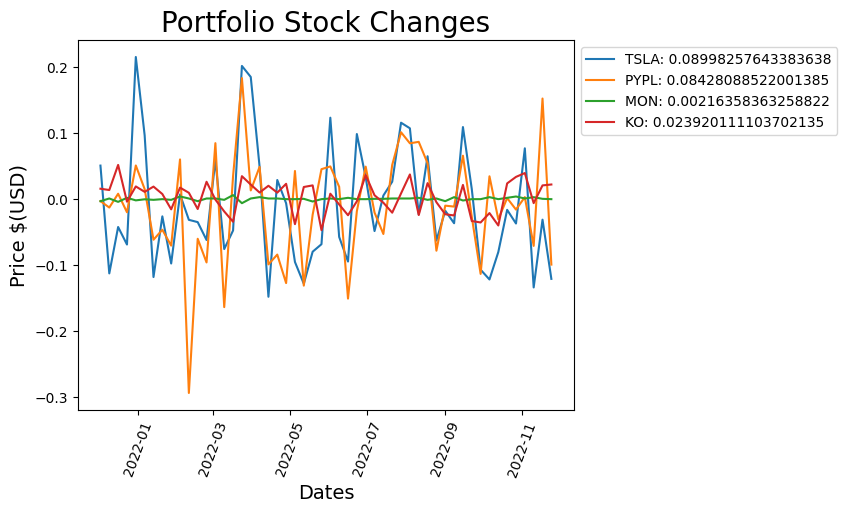

In [33]:
# visualizing the 2 stocks the highest standard deviation and the 2 with the lowest
counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        print(x.ticker + " expected return: " + str(x.companiesDF['pct'].mean()))
        counter = counter+1
        
stockObjects.reverse()

counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        print(x.ticker + " expected return: " + str(x.companiesDF['pct'].mean()))
        counter = counter+1
print()

As we can see, the stock with the highest standard deviation is indeed the riskiest since standard deviation is the aggregate of both the market risk and the idiosyncratic risk

In [22]:
def calculateCorrelation(ticker1, ticker2):
    '''
    purpose:
        calculates the correlation between two stock
    input:
        ticker1 (Stock): Stock object 1
        ticker2 (Stock): Stock object 2
    output: 
        A value between -1 to 1 that represents the correlation
        between the given tickers
    '''
    correlation=pd.DataFrame()
    correlation[ticker1.ticker]=ticker1.companiesDF['pct']
    correlation[ticker2.ticker]=ticker2.companiesDF['pct']
    correlation=correlation.corr()
    correlation=correlation.iloc[0,1]


    return correlation

In [23]:
def selectPortfolio(mainStock, tickerList):
    '''
    purpose:
        to create a portfolio consisted of the stock with the highest standard deviation (stock A)
        and 11 other stocks who has a high correlation with stock A
    Input:
        mainStock (Stock object): the stock with the highest standard deviation
        tickerList (listof Stock objects): used to determine which stock has a high correlation to stock A
    Output:
        A dictionary with Stock objects as the keys and correlation with main stock as the value
    '''
    portfolio = {mainStock:1}
    correlationDict = dict()
    targetNumberofStocks = 12
    
    for ticker in tickerList:
        if ticker.ticker != mainStock.ticker:
            correlationDict[ticker] = calculateCorrelation(mainStock, ticker)

    threshold = 0.95 
    while True:
        # add all stocks which have correlation the mainStock above the threshold
        for key in correlationDict:
            if correlationDict[key] >= threshold:
                portfolio[key] = correlationDict[key]  
        # if too few stocks then restart the process with a lower threshold
        if len(portfolio) < targetNumberofStocks: 
                portfolio = {mainStock:1}
                threshold -= 0.05
        # if too many stocks then restart the process with a higher threshold
        elif len(portfolio) > targetNumberofStocks:
                portfolio = {mainStock:1}
                threshold += 0.00001
        else: # when we have exactly 12 stocks
            break
        
    return portfolio

# sort it
portfolioObj = list(sorted(selectPortfolio(mainStock, stockObjects).items(), key=lambda x:x[1], reverse=True))
highestCorrelationObj = portfolioObj[1][0]
secondHighestCorrelationObj = portfolioObj[2][0]

for pair in portfolioObj:
    print(pair[0].ticker + " and " + mainStock.ticker + ":", pair[1])
portfolioObj = list(dict(portfolioObj).keys()) # turn it into a list of objects for future ease of use

TSLA and TSLA: 1
AAPL and TSLA: 0.7237863830841071
NKE and TSLA: 0.6750385836900422
GM and TSLA: 0.647456129785319
AMZN and TSLA: 0.6231076303029159
MSFT and TSLA: 0.6114562893128407
ACN and TSLA: 0.6033441889329447
QCOM and TSLA: 0.5879472952683744
TXN and TSLA: 0.5691696096092937
SBUX and TSLA: 0.5602355770290411
GOOG and TSLA: 0.5500797557496827
BLK and TSLA: 0.5377556782152982


As we can see, the above stocks all have pretty good correlation with the TSLA, and thus will mostly support TSLA's price movement instead of hindering it

In [24]:
def portfolioFinal(portfolioObj):
    '''
    Purpose:
        to create the Portfolio_Final dataframe as indicated in the assignment
    Inputs:
        portfolioObj (listof Stock objects): a list with Stock objects
    Outputs:
        a dataframe with "Ticker", "Price", "weight", "Value" and "Shares" columns
    '''
    totalWeight = 1
    maxWeight = 0.25
    initialInvestment = 500000
    targetNumberofStocks = 12
    
    # dataframe creation preparation
    tempDict = dict()
    tempPrice = []
    tempShares = []
    tempValue = []
    tempWeight = []
    tempTicker = []

    for ticker in portfolioObj:
        # @TODO change it to 11-25 to 11-26
        price = list(yf.Ticker(ticker.ticker).history(start = "2022-11-23", end = "2022-11-24", interval='1d')['Close'])[0]
        tempPrice.append(price)
        weight = 0

        # assign minimum weighting requirement to the supporting stock
        if(ticker.ticker != mainStock.ticker and ticker.ticker != highestCorrelationObj.ticker and ticker.ticker != secondHighestCorrelationObj.ticker):
            weight = (100/(2*targetNumberofStocks))/100
            totalWeight -= weight
        # assign max weight to the mainStock and the stock with highest correlation to mainStock
        elif(ticker.ticker == mainStock.ticker or ticker.ticker == highestCorrelationObj.ticker):
            weight = maxWeight
            totalWeight -= weight
        # assign appropriate weighting to the stock with second highest correlation to mainStock
        # to satisfy portfolio requirement
        elif(ticker.ticker == secondHighestCorrelationObj.ticker):
            weight = 1 - (((targetNumberofStocks-3) * (100/(2*targetNumberofStocks))/100) + 2 * maxWeight)

        tempWeight.append(weight)
        value = initialInvestment*weight
        tempValue.append(value)
        tempShares.append(value/price)
        tempTicker.append(ticker.ticker)

    # final dataframe creation
    tempDict = {"Ticker":tempTicker, "Price":tempPrice, "Shares":tempShares, 
    "Value":tempValue, "Weight":tempWeight, }
    Portfolio_Final = pd.DataFrame(tempDict)

    # reset the index as required
    Portfolio_Final.index += 1

    return Portfolio_Final

Portfolio_Final = portfolioFinal(portfolioObj)
print("Sanity Check: ")
print("Total Value: $" + str(Portfolio_Final.Value.sum()))
print("Total Weight: " + str(Portfolio_Final.Weight.sum()*100) + "%")
print("Total Value of (Price * Shares): $" + str((Portfolio_Final.Price * Portfolio_Final.Shares).sum()))
Portfolio_Final


Sanity Check: 
Total Value: $500000.0
Total Weight: 100.0%
Total Value of (Price * Shares): $500000.0


,Ticker,Price,Shares,Value,Weight
1,TSLA,183.199997,682.314422,125000.000000,0.250000
2,AAPL,151.070007,827.430952,125000.000000,0.250000
3,NKE,106.650002,586.029059,62500.000000,0.125000
4,GM,40.110001,519.404962,20833.333333,0.041667
5,AMZN,94.129997,221.325124,20833.333333,0.041667
6,MSFT,247.580002,84.147884,20833.333333,0.041667
7,ACN,294.529999,70.734164,20833.333333,0.041667
8,QCOM,125.150002,166.466904,20833.333333,0.041667
9,TXN,178.979996,116.400345,20833.333333,0.041667
10,SBUX,99.519997,209.338164,20833.333333,0.041667


MainStock Std:  0.08998257643383639
portfolio Std:  0.053908153399361614


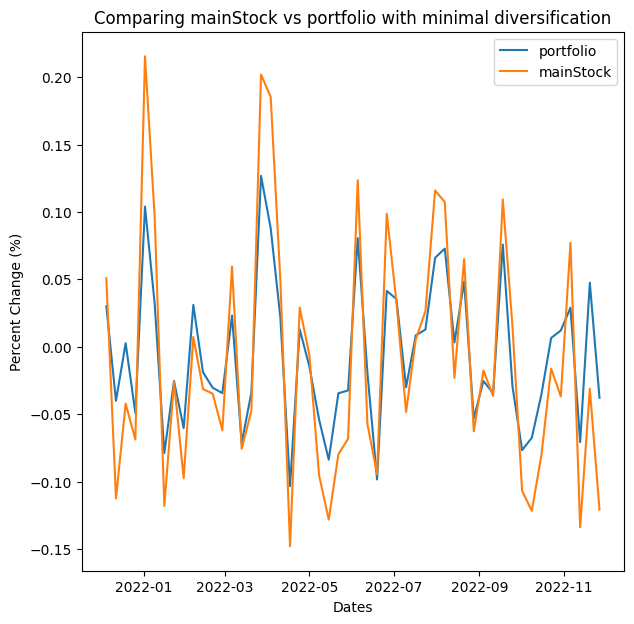

In [26]:
def compare(mainStock, portfolioFinal, portfolioObj):
    temp = pd.DataFrame()
    temp["portfolio"] = portfolioObj[0].companiesDF[portfolioObj[0].ticker]*0
    counter = 0
    for row in portfolioFinal.iterrows():
        # shares * past periods
        temp["portfolio"] += row[1][2]*portfolioObj[counter].companiesDF[portfolioObj[counter].ticker]
        counter += 1
    temp["portfolio"] = temp['portfolio'].pct_change()
    # if entire portfolio is mainstock, we get 4 times as many shares
    temp['mainStock'] = mainStock.companiesDF[mainStock.ticker]*(portfolioFinal.iloc[0,2]*4)
    temp['mainStock'] = temp['mainStock'].pct_change()
    temp.dropna(inplace=True)

    plt.figure(figsize=(7, 7))
    plt.plot(temp.index, temp["portfolio"], label="portfolio")
    plt.plot(temp.index, temp['mainStock'], label="mainStock")
    plt.legend(loc='best')
    plt.xlabel("Dates")
    plt.ylabel("Percent Change (%)")
    plt.title("Comparing mainStock vs portfolio with minimal diversification")
    print("MainStock Std: ", temp['mainStock'].std())
    print("portfolio Std: ", temp['portfolio'].std())

compare(mainStock, Portfolio_Final, portfolioObj)

Everything checks out, and it preserves the risky nature of the main stock

In [27]:
def outputCSV(Portfolio_Final):
    Stocks_Group_12 = pd.DataFrame(Portfolio_Final[['Ticker', 'Shares']])
    Stocks_Group_12.to_csv("Stocks_Group_12.csv")
    return Stocks_Group_12

Stocks_Group_12 = outputCSV(Portfolio_Final)
Stocks_Group_12


,Ticker,Shares
1,TSLA,682.314422
2,AAPL,827.430952
3,NKE,586.029059
4,GM,519.404962
5,AMZN,221.325124
6,MSFT,84.147884
7,ACN,70.734164
8,QCOM,166.466904
9,TXN,116.400345
10,SBUX,209.338164


Comparing our Portfolio to another Portfolio with 20 random Stocks


In [36]:
'''
Purpose: Allows you to combine a large amounts of instances
Input: The List, Do you want to have it randomly selected, Amount if Random
Output: An instance of the combination of the stocks in the List
'''
def combineStocks(objList, randomSelect=False, amount=0):
    
    # If random, find a sample
    if randomSelect:
        objListTemp = random.sample(objList, k=amount)
    #Creating the Portfolio
    randomPortfolio = Stock(objList[0].ticker, objListTemp[0].start, objListTemp[0].end)
    objListTemp.pop(0)
    # Adding the Data
    for instance in objListTemp:
        randomPortfolio.companiesDF[randomPortfolio.ticker] += instance.companiesDF[instance.ticker]
    # Updates the pct_Change and the Name
    randomPortfolio.checkValues()
    randomPortfolio.companiesDF.rename(columns = {randomPortfolio.ticker: 'Random'}, inplace= True)
    randomPortfolio.ticker = 'Random'
    return randomPortfolio

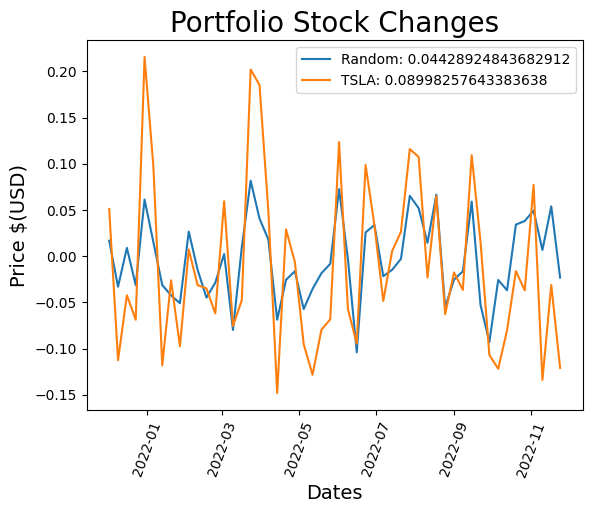

In [43]:
# This code can be run as many times as you wish as the stocks generated are always random
import random

# Creates new portfolio
randomStocks = combineStocks(stockObjects, True, 12)

# Graphs the Changes of the Random Portfolio and the Best Stock
randomStocks.graphChange()
stockObjects.sort()
stockObjects[0].graphChange()

As can be seen, by running 20 random stocks continuously, their standard deviation and percentage change graph are always less that that of the stock that we have chosen.

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

- Robin:
- Jessica:
- Eric: 